<a href="https://colab.research.google.com/github/nee-no/mmWave/blob/master/LSTM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import os
import csv
import re
import sys
import math
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from sklearn.utils import shuffle

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
import random

def generate_array(mode="train"):
    #global current_timestep
    while True:
      in_folder = os.path.join("/content","drive","My Drive","Colab Notebooks","lstm_data")
      reorder = 0

      if(mode=="train"):
        current_timestep = random.randint(0, 39)
        if current_timestep >=31:
          reorder = 1
        else:
          reorder = 0

      elif(mode=="valid"):
        current_timestep = random.randint(40, 45)
        
      elif(mode=="test"):
        current_timestep = random.randint(45, 49)
      
      x = np.load(os.path.join(in_folder, "in_step{}.npy".format(current_timestep)))
      y = np.load(os.path.join(in_folder, "out_step{}.npy".format(current_timestep)))

      if reorder:
        max_num = 40
        repeat_last = 10 - (max_num - current_timestep)

        X = x[:,0:(10-repeat_last),:]
        Y = y[:,0:(10-repeat_last),:]
        X_new = np.zeros((X.shape[0], 10, X.shape[2]))
        Y_new = np.zeros((Y.shape[0], 10, Y.shape[2]))

        for k in range(0, X.shape[0]):
            for i in range(0, X_new.shape[1]):
                if i < X.shape[1]:
                    X_new[k,i,:] = X[k,i,:]
                    Y_new[k,i,:] = Y[k,i,:]
                else:
                    X_new[k,i,:] = X_new[k,i-1,:]
                    Y_new[k,i,:] = Y_new[k,i-1,:]
        X = X_new
        Y = Y_new

      X, Y = shuffle(x, y)

      yield (X,Y)

X_valid = np.load(os.path.join("/content","drive","My Drive","Colab Notebooks","lstm_data", "in_step40.npy"))
Y_valid = np.load(os.path.join("/content","drive","My Drive","Colab Notebooks","lstm_data", "out_step40.npy"))
X_valid = X_valid[:,0:5]
Y_valid = Y_valid[:,0:5]
X_test = np.load(os.path.join("/content","drive","My Drive","Colab Notebooks","lstm_data", "in_step45.npy"))
Y_test = np.load(os.path.join("/content","drive","My Drive","Colab Notebooks","lstm_data", "out_step45.npy"))
X_test = X_test[:,0:5]
Y_test = Y_test[:,0:5]

print(X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)

(863, 5, 23000) (863, 5, 61) (863, 5, 23000) (863, 5, 61)


In [0]:
!pip install livelossplot

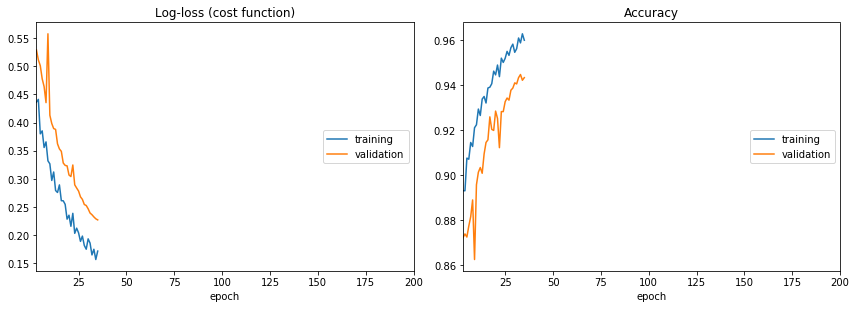

Log-loss (cost function):
training   (min:    0.157, max:    0.488, cur:    0.172)
validation (min:    0.227, max:    0.586, cur:    0.227)

Accuracy:
training   (min:    0.880, max:    0.963, cur:    0.960)
validation (min:    0.857, max:    0.945, cur:    0.943)
863/863 [==============================] - 1215s 1s/step - loss: 0.1718 - acc: 0.9598 - val_loss: 0.2272 - val_acc: 0.9432
Epoch 47/200
 42/863 [>.............................] - ETA: 21:52 - loss: 0.1483 - acc: 0.9651

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Activation, Dense, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from livelossplot import PlotLossesKeras

model = Sequential()
model.add(Bidirectional(LSTM(40, return_sequences=True), input_shape=(None,23000)))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(TimeDistributed(Dense(128, activation="relu")))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(61, activation="softmax")))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              #optimizer=tf.keras.optimizers.Adadelta(lr=1.0),
              optimizer=tf.keras.optimizers.SGD(lr=0.0052),
              #optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

checkpoint_path = "/content/drive/My Drive/Colab Notebooks/lstm_models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',mode='min', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/lstm_models/training1_1.log', append=True, separator=',')

model.load_weights('/content/drive/My Drive/Colab Notebooks/lstm_models/cp-0011.ckpt')

history = model.fit_generator(
    generate_array(mode="train"),
    steps_per_epoch = 863,
    validation_data = (X_valid, Y_valid),
    validation_steps = 863,
    epochs = 200,
    verbose=1,
    shuffle=True,
    initial_epoch = 11,
    callbacks=[es, cp_callback, csv_logger, PlotLossesKeras()])
    #validation_data=(X_test, y_test)
    

In [0]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_num = np.arange(0, len(val_acc), dtype=int)
plot1, = plt.plot(epoch_num, acc)
plot2, = plt.plot(epoch_num, val_acc)
plt.legend([plot1, plot2],['training accuracy', 'validation accuracy'])
plt.show()
plot1, = plt.plot(epoch_num, loss)
plot2, = plt.plot(epoch_num, val_loss)
plt.legend([plot1, plot2],['training loss', 'validation loss'])


In [0]:
import requests

def telegram(message):

    bot_token = '923260274:AAHyCqG6jpPI_xo0x2wJvhGVA_oeUnMf41Y'
    bot_chatID = '763781536'
    send = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + message
    try:
        response = requests.get(send)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)  
    return response.json()

telegram("LSTM bidirectional done!")

train_result = model.evaluate_generator(
    generate_array(mode="train"), 
    steps = 863,
    verbose=0)
print('training loss:',train_result[0])
print('training accuracy:', train_result[1])

valid_result = model.evaluate(X_valid, Y_valid, verbose=0)
print('validation loss:',valid_result[0])
print('validation accuracy:', valid_result[1])

test_result = model.evaluate(X_test, Y_test, verbose=0)
print('testing loss:',test_result[0])
print('testing accuracy:', test_result[1])

message = "LSTM\n" + "test_loss :" + str(test_result[0]) + "\n" + "test_acc :" + str(test_result[1])  + "\n" + "valid_loss :" + str(valid_result[0]) + "\n" + "valid_acc :" + str(valid_result[1]) + "\n" + "train_loss :" + str(train_result[0]) + "\n" + "train_acc :" + str(train_result[1]) 
telegram(message)

In [0]:
print('training loss:',train_result[0])
print('training accuracy:', train_result[1])

print('validation loss:',valid_result[0])
print('validation accuracy:', valid_result[1])

print('testing loss:',test_result[0])
print('testing accuracy:', test_result[1])

In [0]:
val_acc = history.history['val_acc']
acc = history.history['acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

np.savez('/content/drive/My Drive/Colab Notebooks/lstm_models/val_acc.npz', acc=acc, loss=loss, val_acc=val_acc, val_loss=val_loss)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


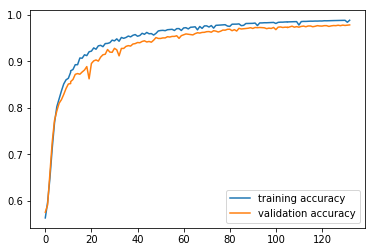

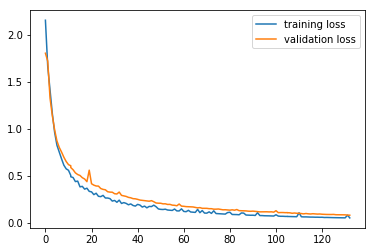

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
training loss: 0.03107207280994843
training accuracy: 0.9933542
validation loss: 0.07820984220449508
validation accuracy: 0.9789108
testing loss: 0.5033239761274632
testing accuracy: 0.89594436


In [0]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

epoch = []
acc = []
loss = []
val_acc = []
val_loss = []

with open('/content/drive/My Drive/Colab Notebooks/lstm_models/training1_compiled.log') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
      # epoch,acc,loss,val_acc,val_loss
      epoch.append(int(row[0]))
      acc.append(float(row[1]))
      loss.append(float(row[2]))
      val_acc.append(float(row[3]))
      val_loss.append(float(row[4]))

plot1, = plt.plot(epoch, acc)
plot2, = plt.plot(epoch, val_acc)
plt.legend([plot1, plot2],['training accuracy', 'validation accuracy'])
plt.show()

plot1, = plt.plot(epoch, loss)
plot2, = plt.plot(epoch, val_loss)
plt.legend([plot1, plot2],['training loss', 'validation loss'])
plt.show()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Activation, Dense, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

model = Sequential()
model.add(Bidirectional(LSTM(40, return_sequences=True), input_shape=(None,23000)))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(TimeDistributed(Dense(128, activation="relu")))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(61, activation="softmax")))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              #optimizer=tf.keras.optimizers.Adadelta(lr=1.0),
              optimizer=tf.keras.optimizers.SGD(lr=0.0052),
              #optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.load_weights('/content/drive/My Drive/Colab Notebooks/lstm_models/cp-0133.ckpt')


train_result = model.evaluate_generator(
    generate_array(mode="train"), 
    steps = 863,
    verbose=0)
print('training loss:',train_result[0])
print('training accuracy:', train_result[1])

valid_result = model.evaluate(X_valid, Y_valid, verbose=0)
print('validation loss:',valid_result[0])
print('validation accuracy:', valid_result[1])

test_result = model.evaluate(X_test, Y_test, verbose=0)
print('testing loss:',test_result[0])
print('testing accuracy:', test_result[1])